# Table of Contents
 <p><div class="lev1 toc-item"><a href="#General-settings" data-toc-modified-id="General-settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General settings</a></div><div class="lev1 toc-item"><a href="#Initial-exploration" data-toc-modified-id="Initial-exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial exploration</a></div><div class="lev2 toc-item"><a href="#Preprocess-datetimes,-distance-and-speed" data-toc-modified-id="Preprocess-datetimes,-distance-and-speed-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess datetimes, distance and speed</a></div><div class="lev2 toc-item"><a href="#Anomalies-and-cleaning" data-toc-modified-id="Anomalies-and-cleaning-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Anomalies and cleaning</a></div><div class="lev3 toc-item"><a href="#Visual-quantile-analysis" data-toc-modified-id="Visual-quantile-analysis-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Visual quantile analysis</a></div><div class="lev2 toc-item"><a href="#Trip-duration-conditioned" data-toc-modified-id="Trip-duration-conditioned-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Trip duration conditioned</a></div><div class="lev1 toc-item"><a href="#City-mapping" data-toc-modified-id="City-mapping-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>City mapping</a></div><div class="lev1 toc-item"><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature engineering</a></div><div class="lev1 toc-item"><a href="#Classification" data-toc-modified-id="Classification-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classification</a></div><div class="lev2 toc-item"><a href="#Error-metric" data-toc-modified-id="Error-metric-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Error metric</a></div><div class="lev2 toc-item"><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Hyperparameter tuning</a></div><div class="lev2 toc-item"><a href="#Submission" data-toc-modified-id="Submission-53"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Submission</a></div><div class="lev1 toc-item"><a href="#Notes" data-toc-modified-id="Notes-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Notes</a></div>

# General settings

In [1]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')

from IPython.display import display

In [2]:
drop_pos = ['dropoff_longitude','dropoff_latitude']
pick_pos = ['pickup_longitude', 'pickup_latitude']

lon_pos = ['pickup_longitude', 'dropoff_longitude']
lat_pos = ['pickup_latitude', 'dropoff_latitude']

position = ['pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude']


week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday']

# Initial exploration

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
display(train.head())
display(train.describe().style)

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

A partir da descrição do pandas, podemos notar, observando os campos min, max, e os quartis 1 e 3:
- Existem viagens com 0 passageiros.
- A duração mais curta é de 1 segundo.
- A duração mais longa é > 3000 x Q3.

## Preprocess datetimes, distance and speed

In [5]:
def add_date_specifics(df, column_name, new_prefix):
    df.loc[:,column_name] = pd.to_datetime(df[column_name])
    
    df[new_prefix +'year'] = df[column_name].dt.year
    df[new_prefix +'month'] = df[column_name].dt.month
    df[new_prefix +'yearday'] = df[column_name].dt.dayofyear
    df[new_prefix +'hour'] = df[column_name].dt.hour
    df[new_prefix +'minute'] = df[column_name].dt.minute
    df[new_prefix +'weekday'] = df[column_name].dt.weekday_name
    df[new_prefix +'weeknum'] = df[column_name].dt.weekday
    df[new_prefix +'weekend'] = train['pickup_weekday'].isin(['Saturday', 'Sunday'])

def add_distances(df):
    """
    Abaixo usamos a aproximação euclideana, ignorando a curvatura da terra,
    por tratarmos de uma unica cidade
    """
    ny_lat = 40.7 # From wikipedia
    R = 6371 # From wikipedia
    deg_rad_ratio = np.pi/180
    conversion = np.array([R*deg_rad_ratio, R*deg_rad_ratio*np.cos(ny_lat*deg_rad_ratio)])
    
    df['line_distance'] = np.sqrt((((df[pick_pos].values - df[drop_pos].values)*conversion)**2).sum(axis=1))
    df['manh_distance'] = np.abs(((df[pick_pos].values - df[drop_pos].values)*conversion)).sum(axis=1)
    #
    #df.apply(lambda x: great_circle(x[pick_pos], x[drop_pos]), axis=1)
    
def add_speed(df):
    """ Velocidade em km/h"""
    df['speed(km/h)'] = 3600*df['line_distance']/df['trip_duration']
    df['manhattan speed(km/h)'] = 3600*df['manh_distance']/df['trip_duration']    

In [6]:
whole = train.append(test)

In [7]:
add_date_specifics(train, 'pickup_datetime', 'pickup_')
add_date_specifics(train, 'dropoff_datetime', 'dropoff_')
add_distances(train)
add_speed(train)
train['log_trip_duration'] = np.log10(train['trip_duration']+1)

add_date_specifics(test, 'pickup_datetime', 'pickup_')
add_distances(test)

## Anomalies and cleaning

In [8]:
train['duration_from_date'] = (train['dropoff_datetime']-train['pickup_datetime']).dt.total_seconds().astype(int)
print('Number of duration inconsistencies:', 
      (train.duration_from_date != train.trip_duration).sum(), 
      '(time provided vs time from datetime diff)')

Number of duration inconsistencies: 0 (time provided vs time from datetime diff)


In [9]:
display('Train:',train.isnull().sum(), 'Test: ', test.isnull().sum())

'Train:'

id                       0
vendor_id                0
pickup_datetime          0
dropoff_datetime         0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
store_and_fwd_flag       0
trip_duration            0
pickup_year              0
pickup_month             0
pickup_yearday           0
pickup_hour              0
pickup_minute            0
pickup_weekday           0
pickup_weeknum           0
pickup_weekend           0
dropoff_year             0
dropoff_month            0
dropoff_yearday          0
dropoff_hour             0
dropoff_minute           0
dropoff_weekday          0
dropoff_weeknum          0
dropoff_weekend          0
line_distance            0
manh_distance            0
speed(km/h)              0
manhattan speed(km/h)    0
log_trip_duration        0
duration_from_date       0
dtype: int64

'Test: '

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
pickup_year           0
pickup_month          0
pickup_yearday        0
pickup_hour           0
pickup_minute         0
pickup_weekday        0
pickup_weeknum        0
pickup_weekend        0
line_distance         0
manh_distance         0
dtype: int64

Podemos ver que não há valores faltando nem no conjunto de treino nem no de teste.

---

##### Limpeza por distância mínima

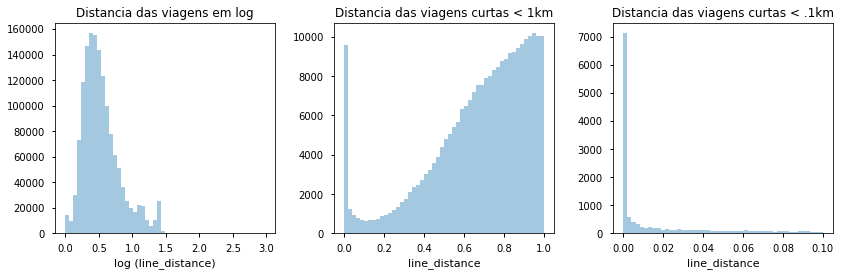

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.distplot(np.log10(train['line_distance']+1), kde=False); plt.xlabel('log (line_distance)');
plt.title('Distancia das viagens em log')
plt.subplot(1,3,2)
plt.title('Distancia das viagens curtas < 1km')
sns.distplot(train['line_distance'][train['line_distance']<1], kde=False);
plt.subplot(1,3,3)
plt.title('Distancia das viagens curtas < .1km')
sns.distplot(train['line_distance'][train['line_distance']<.1], kde=False);

plt.tight_layout()

Notamos que existem muitas viagens que não mudam de lugar, provavelmente problemas na utilização do dispositivo pelos taxistas.

Removeremos as viagens com tamanho < .1km, que é aproximadamente 1 quarteirão. As viagens de tamanho 0 serão removidas juntamente.

---

In [12]:
train = train[train['line_distance']>.1]

---

##### Limpeza por velocidade máxima

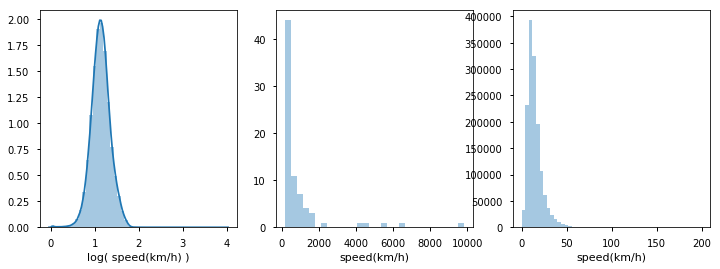

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.distplot(np.log10(train['speed(km/h)']+1)); plt.xlabel('log( speed(km/h) )');

plt.subplot(1,3,2)
ax=sns.distplot(train['speed(km/h)'][train['speed(km/h)'] > 200], kde=False); 

plt.subplot(1,3,3)
ax=sns.distplot(train['speed(km/h)'][train['speed(km/h)'] < 200], kde=False); 

De acordo com [esse site](http://www.speed-limits.com/newyork.htm) e [esse](https://nytrafficticket.com/fastest-road-in-america-and-maximum-speed-limits-in-new-york/), a velocidade maxima em Nova York é 65mph (~104km/h), somente nas rodovias rurais.

Achamos razoável assumir um limite máximo de 200km/h para o nosso dataset, levando em conta que as distâncias medidas são aproximadas. Essa decisão é bastante conservadora, visto que a distância em linha reta tenderá a _subestimar_ as distâncias e as velocidades, e 200km/h é uma velocidade bastante difícil de ser alcançada.

---

In [14]:
train = train[train['speed(km/h)'] < 200]

---

##### Limpeza por passageiros

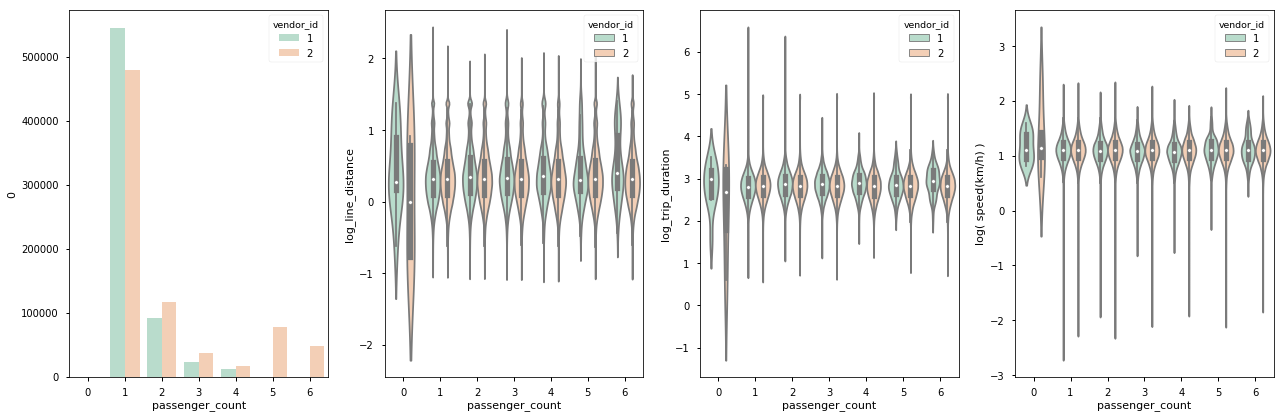

In [40]:
train['log_line_distance'] = np.log10(train['line_distance'])
train['log( speed(km/h) )'] = np.log10(train['speed(km/h)'])

plt.figure(figsize=(18,6))

ax=plt.subplot(1,4,1)
sns.barplot(x='passenger_count', y=0, hue='vendor_id', data=train.groupby(['vendor_id','passenger_count']).apply(len).reset_index(), ax = ax, palette = 'Pastel2')

ax=plt.subplot(1,4,2)
sns.violinplot(x='passenger_count', y='log_line_distance', hue='vendor_id', data=train, ax = ax, palette = 'Pastel2')

ax=plt.subplot(1,4,3)
sns.violinplot(x='passenger_count', y='log_trip_duration', hue='vendor_id', data=train, ax = ax, palette = 'Pastel2')

ax=plt.subplot(1,4,4)
sns.violinplot(x='passenger_count', y='log( speed(km/h) )', hue='vendor_id', data=train, ax = ax, palette = 'Pastel2')

plt.tight_layout()

Podemos ver que há poucas viagens com 0 passageiros, e que as distribuições são semelhantes aos outros tipos de viagem.

As viagens com passageiros > 6 foram removidas em passos anteriores, da distância mínima e velocidade.

---

##### Limpeza por duração máxima

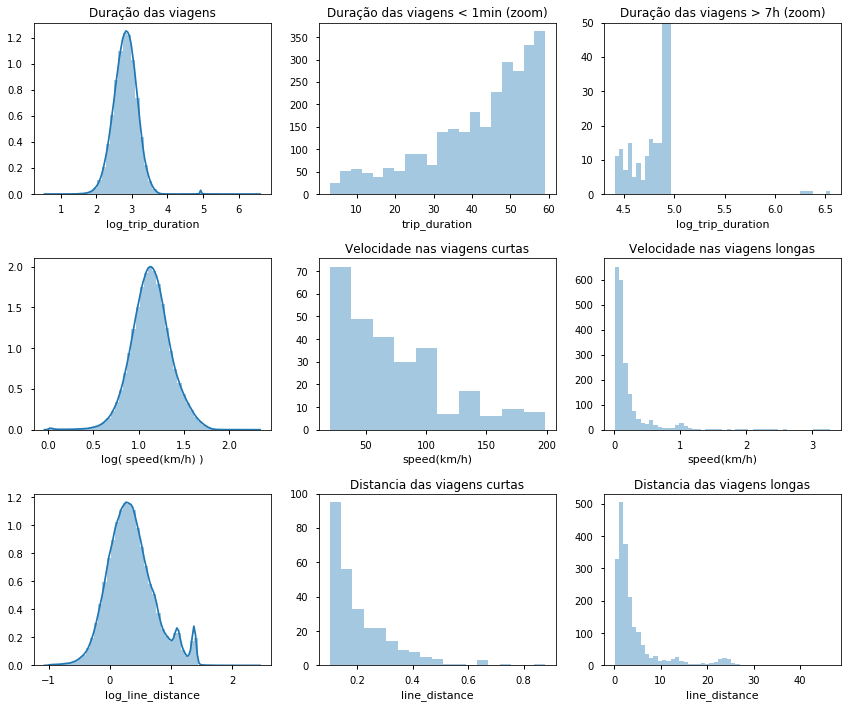

In [59]:
plt.figure(figsize=(12,10))

plt.subplot(3,3,1)
sns.distplot(train['log_trip_duration']); plt.title('Duração das viagens')
plt.subplot(3,3,2)
sns.distplot(train['trip_duration'][train['trip_duration']<60], kde=False); plt.title('Duração das viagens < 1min (zoom)')
plt.subplot(3,3,3)
sns.distplot(train['log_trip_duration'][train['log_trip_duration']>4.4], kde=False); 
plt.title('Duração das viagens > 7h (zoom)'); plt.ylim(0,50);


plt.subplot(3,3,4)
sns.distplot(np.log10(train['speed(km/h)']+1)); plt.xlabel('log( speed(km/h) )');
plt.subplot(3,3,5)
sns.distplot( train['speed(km/h)'][train['trip_duration'] < 20], kde=False ); 
plt.title('Velocidade nas viagens curtas')
plt.subplot(3,3,6)
ax=sns.distplot( train['speed(km/h)'][train['log_trip_duration']>4.4], kde=False )
plt.title('Velocidade nas viagens longas')

#plt.xlabel('log( speed(km/h) )');
plt.subplot(3,3,7)
sns.distplot( train['log_line_distance'], kde=True )
plt.subplot(3,3,8)
sns.distplot( train['line_distance'][train['trip_duration'] < 20], kde=False )
plt.title('Distancia das viagens curtas')
plt.subplot(3,3,9)
sns.distplot( train['line_distance'][train['log_trip_duration']> 4.4], kde=False )
plt.title('Distancia das viagens longas')
plt.tight_layout()

Não parece razoável haverem tantas viagens com duração próxima a 1 dia, (log_trip_duration = 5), mas a duração > 10 dias é completamente não razoável, e provavelmente houve problema no dispositivo, que ficou ligado sem parar.

In [63]:
train = train[train.log_trip_duration<6]

##### Limpeza por localização

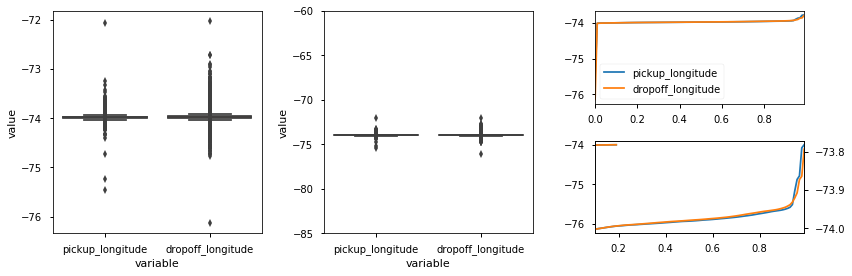

In [64]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.boxplot(x='variable', y='value', data=train[lon_pos].melt())
plt.subplot(1,3,2)
sns.boxplot(x='variable', y='value', data=train[lon_pos].melt()); plt.ylim(-85, -60)
ax=plt.subplot(2,3,3)
train[lon_pos][train[lon_pos]>-90].quantile(np.arange(100)/100).plot(ax=ax)
ax=plt.subplot(2,3,6)
train[lon_pos][train[lon_pos]>-90].quantile(np.arange(20)/100).plot(ax=ax,legend=False);
ax=ax.twinx()
train[lon_pos][train[lon_pos]>-90].quantile(np.arange(10,100)/100).plot(ax=ax,legend=False);

plt.tight_layout()

Text(0.5,1,'Dropoff')

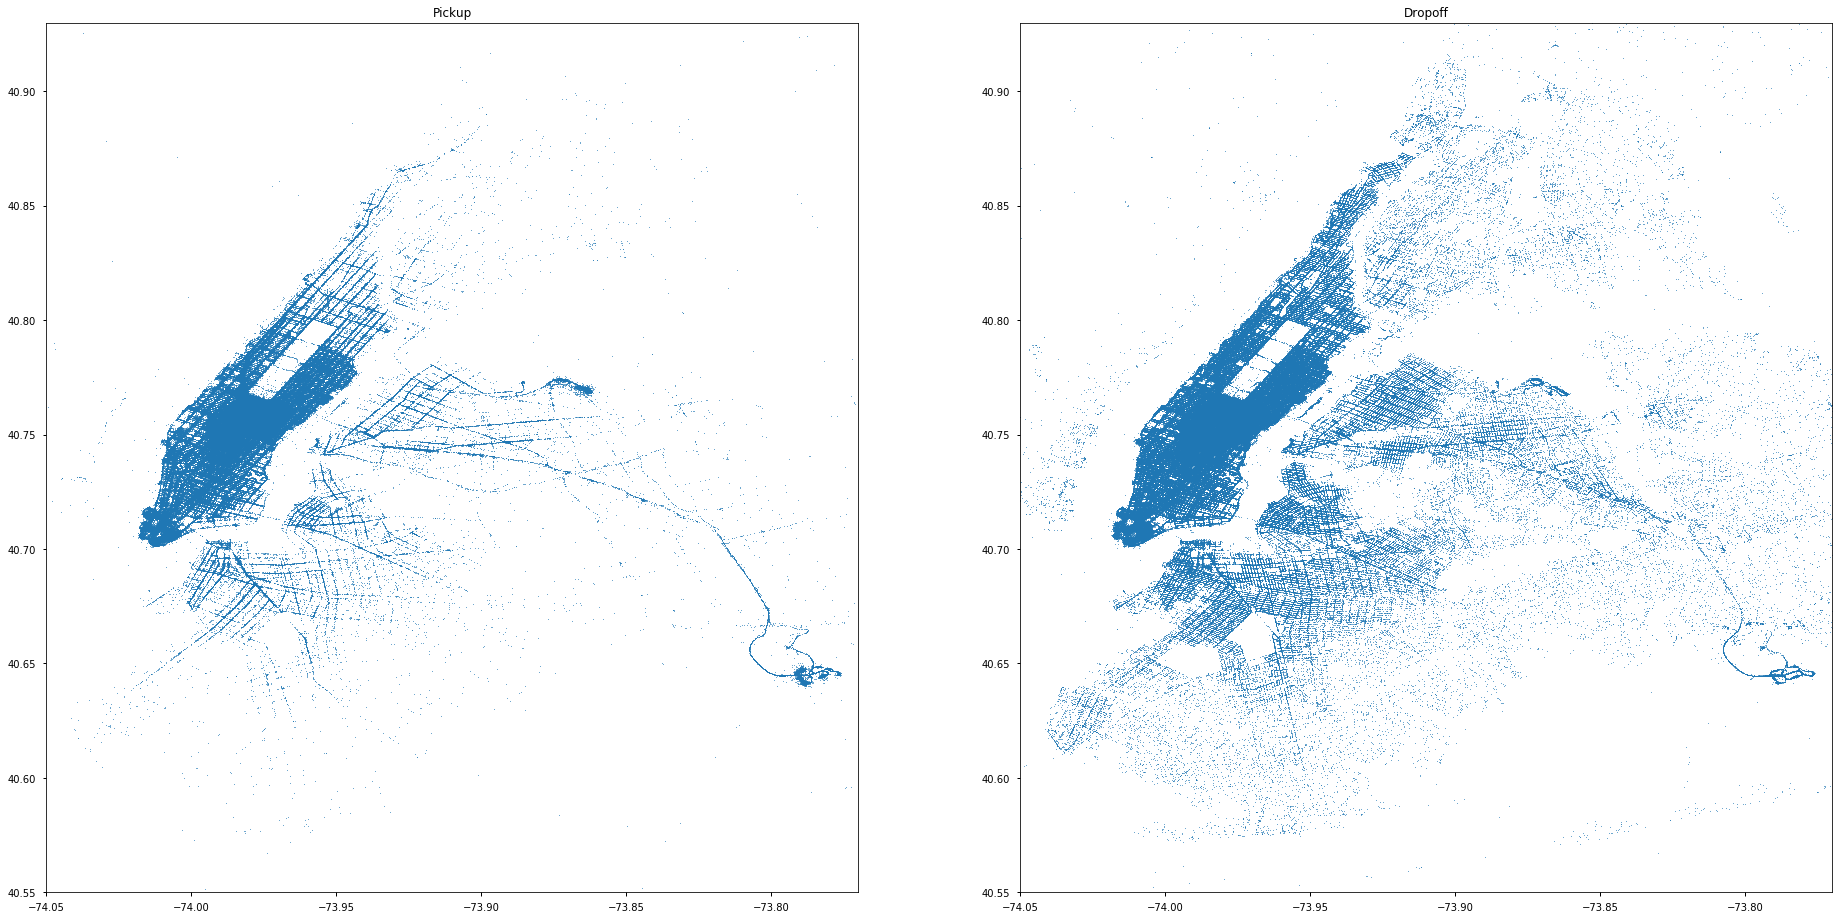

In [21]:
plt.figure(figsize=(32,16))

plt.subplot(1,2,1)
plt.scatter(train['pickup_longitude'], train['pickup_latitude'], s=.3);
plt.xlim(-74.05, -73.77); plt.ylim(40.55,40.93); plt.title('Pickup')

plt.subplot(1,2,2)
plt.scatter(train['dropoff_longitude'], train['dropoff_latitude'], s=.3);
plt.xlim(-74.05, -73.77); plt.ylim(40.55,40.93); plt.title('Dropoff')

Manualmente e por iterações, foram decididos limites para as coordenadas de latitude e longitude que mantivessem as caracteristicas visualmente importantes no mapa, e que serão usadas nos mapas a partir daqui.

No mapa dos pickups é fácil notar dois 'bumps' fora da cidade de Manhattan. Uma pesquisa rápida no _google maps_ mostra que se tratam do aeroporto regional de La Guardia, mais próximo à cidade, e do aeroporto internacional Jonh F. Kennedy, mais distante.

In [23]:
min_lon, max_lon = -74.05, -73.77
min_lat, max_lat = 40.55, 40.93

min_pos = pd.Series(dict(zip(position,[min_lon,min_lat, min_lon, min_lat])))
max_pos = pd.Series(dict(zip(position,[max_lon,max_lat, max_lon, max_lat])))
is_central = ((train[position] > min_pos) & (train[position] < max_pos)).sum(axis=1)==4

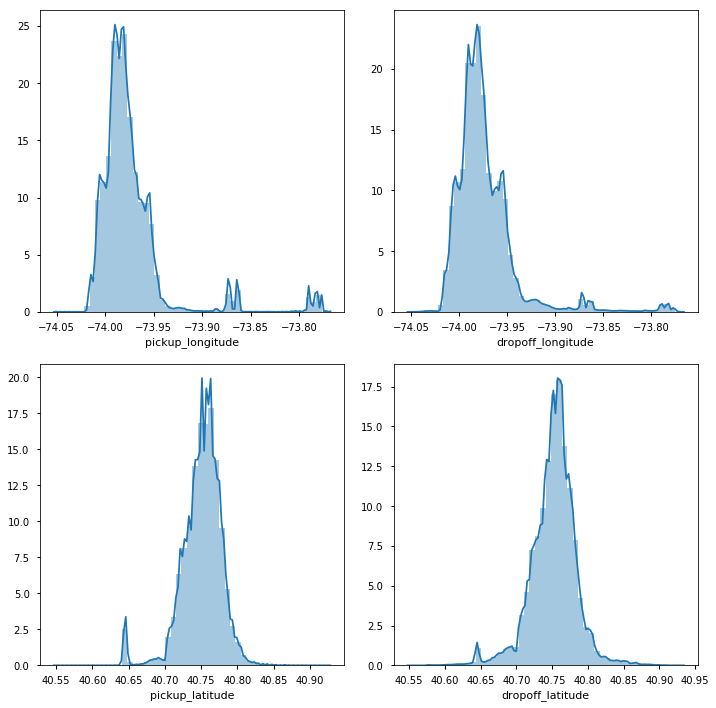

In [24]:
plt.figure(figsize=(10,10))

ax = plt.subplot(2,2,1)
sns.distplot(train[is_central]['pickup_longitude'])
ax = plt.subplot(2,2,2)
sns.distplot(train[is_central]['dropoff_longitude'])
ax = plt.subplot(2,2,3)
sns.distplot(train[is_central]['pickup_latitude'])
ax = plt.subplot(2,2,4)
sns.distplot(train[is_central]['dropoff_latitude'])

plt.tight_layout()

---

### Visual quantile analysis

In [41]:
quants = pd.DataFrame()
for p in np.arange(0,1.001,.001):
    quants = quants.append(train[position].quantile(p))

Text(0.5,1,'')

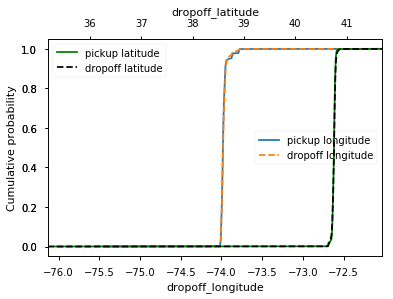

In [42]:
quants[lon_pos].reset_index().set_index(['pickup_longitude'])['index'].plot(label='pickup longitude')
quants[lon_pos].reset_index().set_index(['dropoff_longitude'])['index'].plot(linestyle='--',label='dropoff longitude')
plt.legend(loc='center right')

plt.twiny()
quants[lat_pos].reset_index().set_index(['pickup_latitude'])['index'].plot(color='g',label='pickup latitude')
quants[lat_pos].reset_index().set_index(['dropoff_latitude'])['index'].plot(linestyle='--',color='k', label='dropoff latitude')

plt.ylabel('Cumulative probability')
plt.legend(loc='upper left')
plt.title('')

É possível ver que ainda possuimos outliers muito distantes tanto para latitude quanto longitude.

## Trip duration conditioned

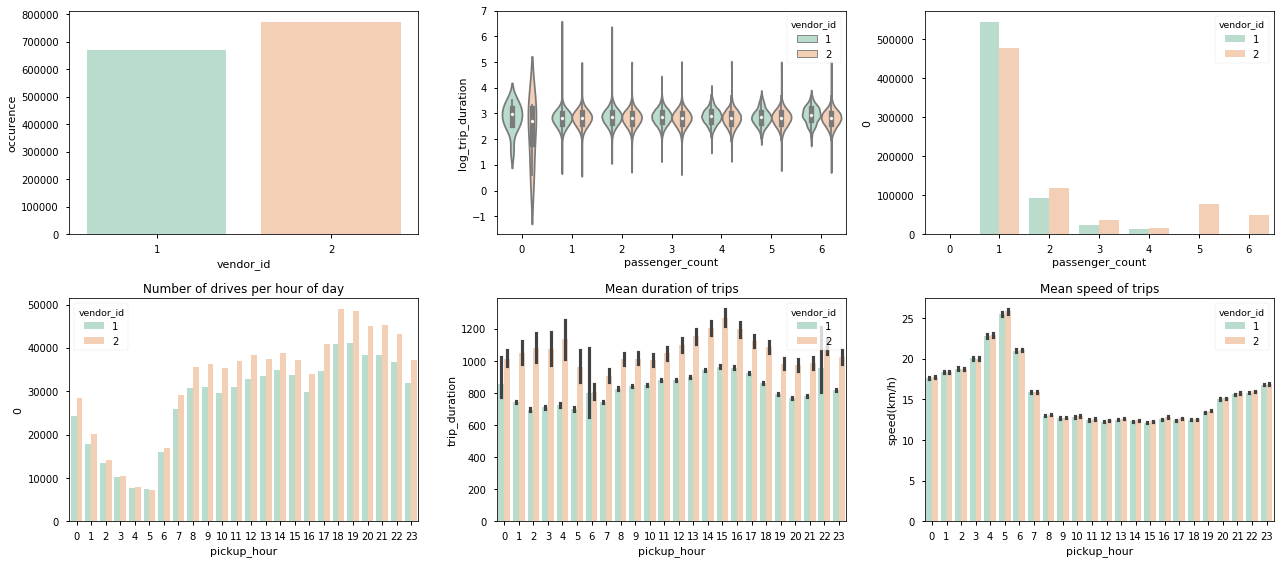

In [43]:
plt.figure(figsize=(18,8))


ax=plt.subplot(2,3,1)
sns.barplot(x='vendor_id', y=0, data= train.groupby('vendor_id').apply(len).reset_index(), palette = 'Pastel2')
plt.ylabel('occurence')

ax=plt.subplot(2,3,2)
sns.violinplot(x='passenger_count', y='log_trip_duration', hue='vendor_id', data=train, ax = ax, palette = 'Pastel2')

ax=plt.subplot(2,3,3)
sns.barplot(x='passenger_count', y=0, hue='vendor_id', data=train.groupby(['vendor_id','passenger_count']).apply(len).reset_index(), ax = ax, palette = 'Pastel2')

ax=plt.subplot2grid((2,3),(1,0))
sns.barplot(x='pickup_hour', y=0, hue='vendor_id', palette = 'Pastel2', 
             data = train.groupby(['vendor_id', 'pickup_hour']).apply(len).reset_index())
plt.title('Number of drives per hour of day')

ax=plt.subplot2grid((2,3),(1,1))
sns.barplot(x='pickup_hour', y='trip_duration', data=train, ax=ax, hue='vendor_id', palette = 'Pastel2')
plt.title('Mean duration of trips')

ax=plt.subplot2grid((2,3),(1,2))
sns.barplot(x='pickup_hour', y='speed(km/h)', data=train, ax=ax, hue='vendor_id', palette = 'Pastel2')
plt.title('Mean speed of trips')

plt.tight_layout()

- A feature vendor_id provavelmente se trata da empresa de taxi.
- A maior parte das viagens com mais de 4 passageiros é da empresa 2.
- A maior parte das viagens de taxi possui apenas 1 passageiro.

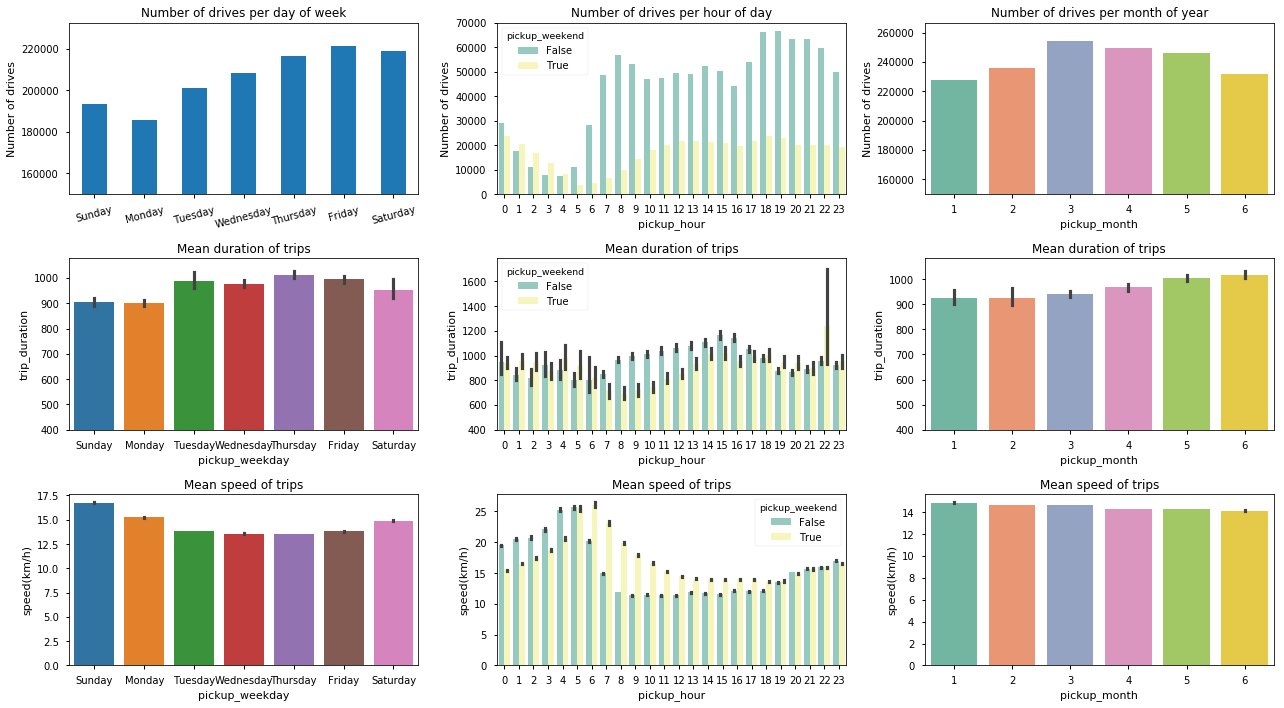

In [44]:
plt.figure(figsize=(18,10))

# Weekday-------------
ax=plt.subplot2grid((3,3),(0,0))
train.pickup_weekday.value_counts()[week].plot.bar(ax=ax, rot=15)
plt.title('Number of drives per day of week'); plt.ylim(150000); plt.ylabel('Number of drives')

ax=plt.subplot2grid((3,3),(1,0))
sns.barplot(x='pickup_weekday', y='trip_duration', data=train, order=week, ax=ax)
plt.title('Mean duration of trips'); plt.ylim(400);

ax=plt.subplot2grid((3,3),(2,0))
sns.barplot(x='pickup_weekday', y='speed(km/h)', data=train, order=week, ax=ax)
plt.title('Mean speed of trips'); 

# Hour -------------
ax=plt.subplot2grid((3,3),(0,1))
sns.barplot(x='pickup_hour', y=0, hue='pickup_weekend', palette = 'Set3', 
             data = train.groupby(['pickup_weekend', 'pickup_hour']).apply(len).reset_index())
plt.title('Number of drives per hour of day'); plt.ylabel('Number of drives')

ax=plt.subplot2grid((3,3),(1,1))
sns.barplot(x='pickup_hour', y='trip_duration', data=train, ax=ax, hue='pickup_weekend', palette = 'Set3')
plt.title('Mean duration of trips'); plt.ylim(400);

ax=plt.subplot2grid((3,3),(2,1))
sns.barplot(x='pickup_hour', y='speed(km/h)', data=train, ax=ax, hue='pickup_weekend', palette = 'Set3')
plt.title('Mean speed of trips');

# Month-------------
ax=plt.subplot2grid((3,3),(0,2))
sns.barplot(x='pickup_month', y=0,
                data=train.groupby('pickup_month').apply(len).reset_index(), palette='Set2')
plt.title('Number of drives per month of year'); plt.ylim(150000); plt.ylabel('Number of drives')

ax = plt.subplot2grid((3,3),(1,2))
sns.barplot(x='pickup_month', y='trip_duration', data=train, ax=ax, palette='Set2')
plt.title('Mean duration of trips'); plt.ylim(400);

ax=plt.subplot2grid((3,3),(2,2))
sns.barplot(x='pickup_month', y='speed(km/h)', data=train, ax=ax, palette='Set2')
plt.title('Mean speed of trips');


plt.tight_layout()

É possivel notar uma diferença clara entre os dias da semana e os fins de semana, entre as 5 da manha e as 18. As viagens costumam ser muito mais lentas nos dias da semana, o que provavelmente se deve ao commute, da ida e volta diária ao trabalho.

Sem atenção às horas, ainda é possivel ver uma diferença de velocidade nas viagens, mais lentas no meio da semana, e que curiosamente se mantém altas nas segundas feiras, mesmo sendo um dia de trabalho.

# City mapping

In [45]:
def citymap(df, pos = pick_pos, func=len, precision=4000):
    lats = np.arange( int(precision*train[is_central]['dropoff_latitude'].min()),
                      int(precision*train[is_central]['dropoff_latitude'].max())+1)
    lons = np.arange( int(precision*train[is_central]['dropoff_longitude'].min()),
                      int(precision*train[is_central]['dropoff_longitude'].max())+1)
    
    densemap = np.zeros((lons.shape[0], lats.shape[0]))
    local = df.copy()
    local[pos] = local[pos].apply(np.around, decimals=4)
    sparse_vals = local.groupby(pos).apply(func)
    for (lon, lat), count in sparse_vals.iteritems():
        i = int(precision*lon-lons[0])
        j = int(precision*lat-lats[0])
        if i < densemap.shape[0] and j < densemap.shape[1] and i>=0 and j>=0:
            densemap[i,j] = count
    return pd.DataFrame(densemap, index = pd.Index(lons/precision, name='Longitude'), columns=pd.Index(lats/precision, name='Latitude'))

In [46]:
pickmap = np.log10(citymap(train[is_central]) +1)
dropmap = np.log10(citymap(train[is_central], pos = drop_pos) +1)

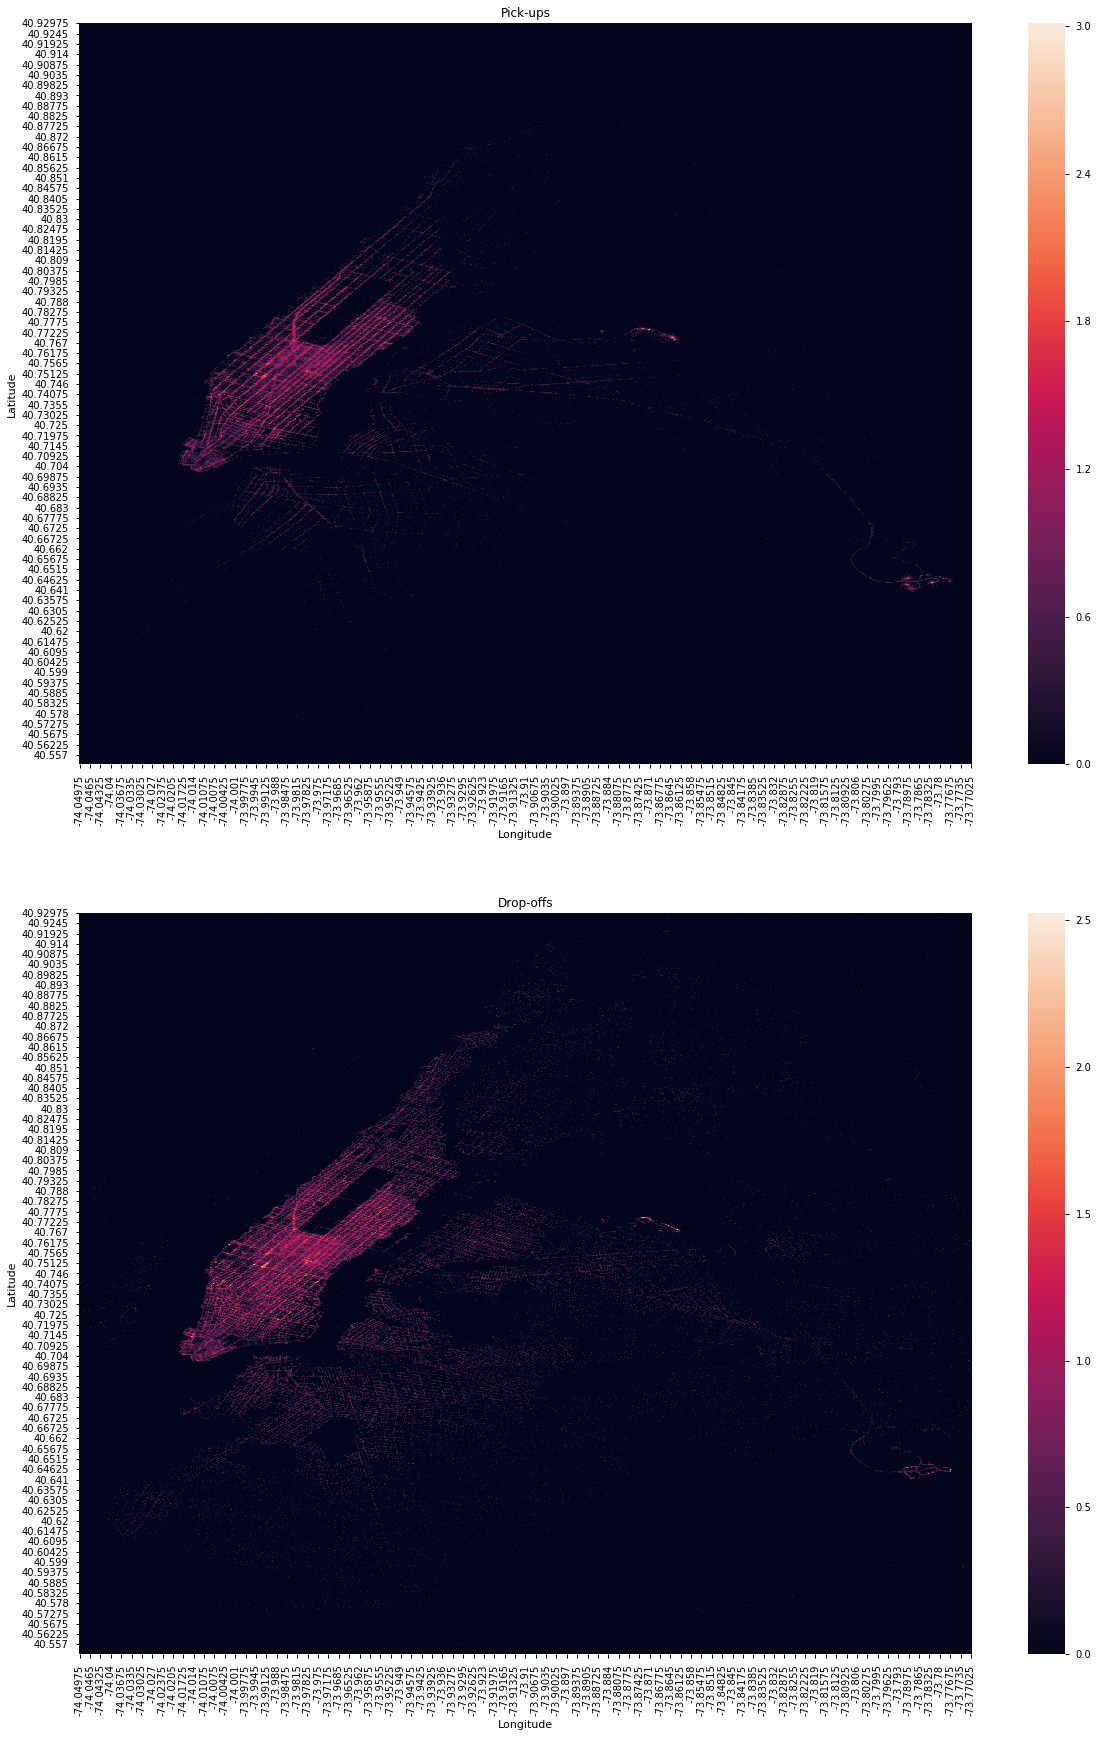

In [47]:
plt.figure(figsize=(20,30))
ax = plt.subplot(2,1,1)
sns.heatmap(pickmap.T[::-1]); plt.title('Pick-ups')
ax = plt.subplot(2,1,2)
sns.heatmap(dropmap.T[::-1]); plt.title('Drop-offs');

In [48]:
del(pickmap)
del(dropmap)

Observando os mapas de pickup e dropoff, e possivel notar que existe muito mais consistencia nos pickups, o que e bastante razoavel, levando em conta que os taxistas devem pegar passageiros em vias movimentadas e em seus respectivos pontos de taxi, e provavelmente nao passam muito tempo procurando passageiros em vias pequenas. Essa analise considera que o meio mais comum de pegar taxi, para essas duas empresas em questao, ainda e "presencial", em oposiçao a atraves de aplicativos. 

Outra possibilidade e que os passageiros tenham menor tendencia a pegar taxis na ida para a cidade, talvez pela maior facilidade do transporte publico nessa direçao, e peguem mais comumente na volta para casa, ou em viagens relacionadas a trabalho dentro da propria cidade. Essa hipotese bate com o fato de que o numero de taxis e muito maior nas horas entre 7h e 23h, em uma diferença que ocorre principalmente nos dias da semana, enquanto no fim de semana a quantidade de taxis e menos variavel.

O mais provavel e que ambos os fatores exerçam alguma influencia sobre os dados.

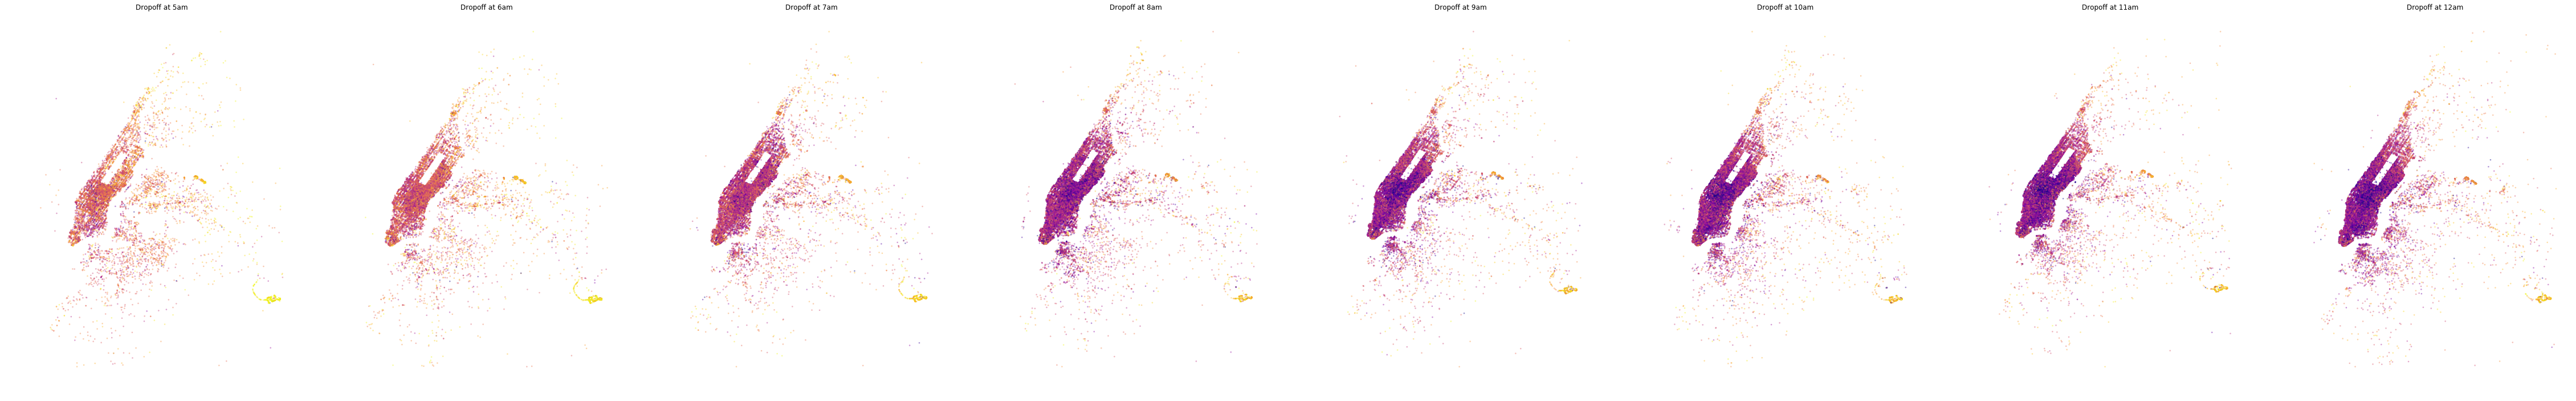

In [49]:
plt.figure(figsize=(80,12))

for i in range(8):
    plt.subplot(1,8,i+1)
    to_plot = (train['dropoff_hour']==i+5) & is_central
    plt.scatter(train[to_plot]['dropoff_longitude'], train[to_plot]['dropoff_latitude'], 
                    s=5, alpha=.4, c=np.log10(train[to_plot]['speed(km/h)']), cmap='plasma', vmin=.7, vmax=1.7)
    plt.title('Dropoff at %dam'%(i+5))
    plt.axis('off')

- É possível ver o aumento do trânsito em Manhattan nas primeiras horas do dia, junto com o aumento da densidade de viagens. 
- As viagens para o aeroporto JFK continuam sendo bastante rápidas em geral. 
- Não há mudança aparente de densidade das viagens para fora de Manhattan.

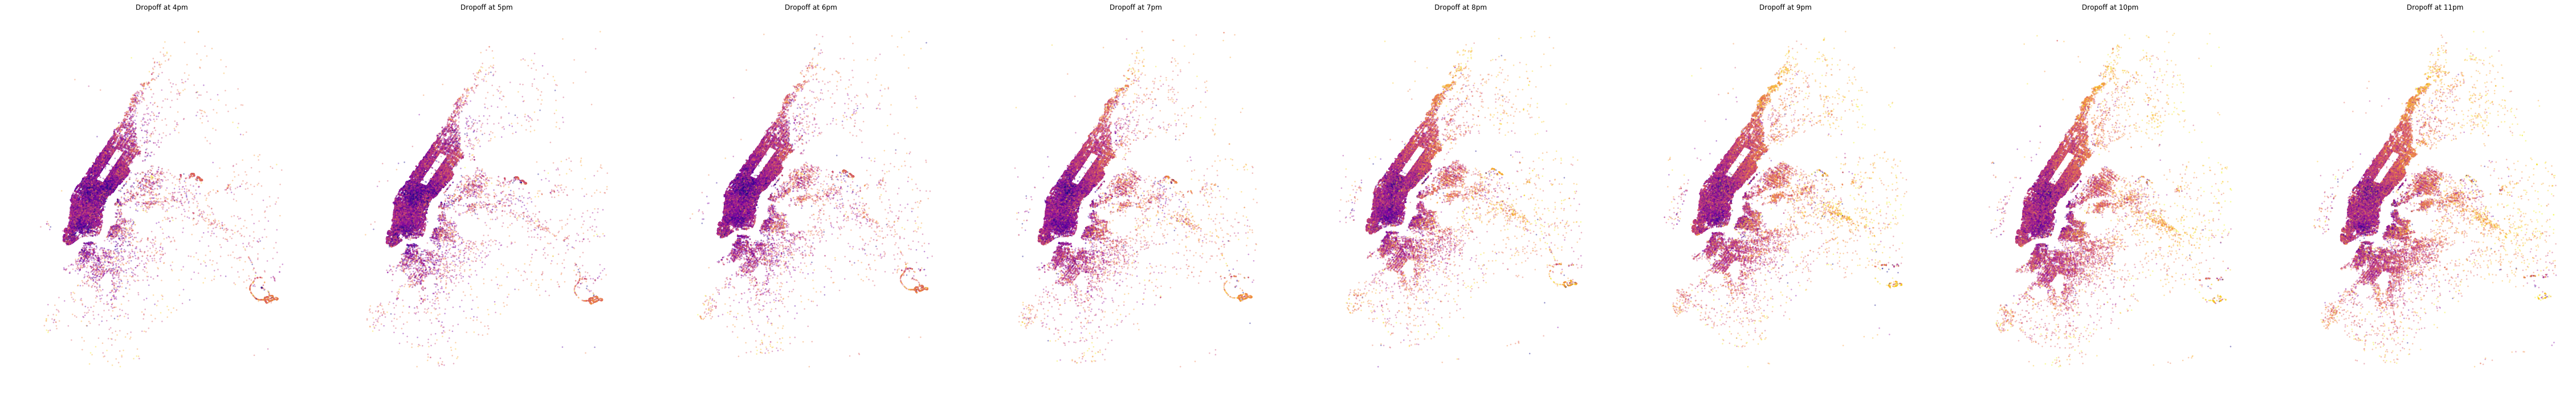

In [50]:
plt.figure(figsize=(80,12))

for i in range(8):
    plt.subplot(1,8,i+1)
    to_plot = (train['dropoff_hour']==i+16) & is_central
    plt.scatter(train[to_plot]['dropoff_longitude'], train[to_plot]['dropoff_latitude'], 
                    s=5, alpha=.4, c=np.log10(train[to_plot]['speed(km/h)']), cmap='plasma', vmin=.7, vmax=1.7)
    plt.title('Dropoff at %dpm'%(i+4))
    plt.axis('off')

- É possível perceber que, enquanto a densidade de viagens terminando no centro de Manhattan diminue com a chegada da noite, ela aumenta perceptivelmente nos arredores, indicando provavelmente a volta de trabalhadores para suas casas.

- A velocidade média das viagens, indicada pela cor dos pontos, indica uma melhora gradual no transito, mais rapida na periferia, especialmente mais distante da cidade entre os aeroportos. Às 23h ainda sao lentas as viagens para a parte mais central da cidade.

# Feature engineering

In [28]:
raw_feat_list = ['vendor_id','pickup_hour','pickup_month','pickup_weeknum', 'store_and_fwd_flag',
                 'pickup_weekend', 'line_distance', 'manh_distance'] + position
onehot_feat_list = ['pickup_hour', 'pickup_month', 'pickup_weekday']

In [23]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)

def one_hot_df(df, feature):    
    onehot = OneHotEncoder(sparse=False)
    dense_X = onehot.fit_transform(df[feature].values.reshape(-1,1))
    return pd.DataFrame( dense_X, columns = ['%s_%d'%(feature, i) for i in onehot.active_features_] )

In [100]:
X = pd.get_dummies(train[onehot_feat_list], columns = onehot_feat_list).join(train[raw_feat_list])
X['store_and_fwd_flag'] = X['store_and_fwd_flag'] == 'Y' 

y = train.log_trip_duration

Xtest = pd.get_dummies(test[onehot_feat_list], columns = onehot_feat_list).join(test[raw_feat_list])
Xtest['store_and_fwd_flag'] = Xtest['store_and_fwd_flag'] == 'Y' 

# Classification

In [74]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import cross_val_score

## Error metric

In [66]:
def rmsle(y_true,y_pred):
    """
    From https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError
    """
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

def rmse(y_true,y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(y_pred - y_true).mean() ** 0.5

from sklearn.metrics import make_scorer

rmsle_score = make_scorer(rmsle)
rmse_score = make_scorer(rmse)

## Hyperparameter tuning

In [128]:
from skopt import gp_minimize

def optimize(X, y, n_calls=80, n_random_starts=10):
    hyperparameter_space = [(1,15),
                            (0.01,1.),
                            (10,300),
                            (1e-6,10.,"log-uniform"),
                            (1,30),
                            (1e-6,1.,"log-uniform"),
                            (1e-6,1.,"log-uniform"),
                            (1e-2,1.,"log-uniform"),
                            (1e-2,1.,"log-uniform")]
    hyperparameter_names = ['max_depth', 'learning_rate', 'n_estimators', 
                            'gamma', 'min_child_weight', 'reg_alpha', 'reg_lambda', 
                            'colsample_bytree', 'subsample']
    def objective_(params):
        parameters = dict(zip(hyperparameter_names, params))
        print(parameters)
        score = np.mean(np.log(10)*cross_val_score(XGBRegressor(**parameters), X, y, cv=3, scoring=rmse_score))
        return score

    return gp_minimize(objective_, hyperparameter_space, n_calls=n_calls,n_random_starts=n_random_starts, n_jobs=3,verbose=3)

In [ ]:
%%time
res = optimize(X, y)

In [ ]:
best = {'max_depth': 11, 'learning_rate': 0.21476942062372031, 'n_estimators': 287, 
         'gamma': 2.3074723022921413e-06, 'min_child_weight': 16, 'reg_alpha': 0.5815787682811846, 
         'reg_lambda': 0.60169547700624582, 'colsample_bytree': 0.78028984074973284, 'subsample': 0.36043975312396048}

In [ ]:
xgb = XGBRegressor(**best)
xgb.fit(X, y)
ypred = xgb.predict(Xtest)

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,15))
plot_importance(xgb, ax=ax)

![title](PI.png)

## Submission

In [114]:
sub = pd.DataFrame(test.id)
sub['trip_duration'] = 10**ypred

sub.to_csv('my_sub.csv',index=False)

![title](holdout_score_kaggle.png)

# Notes

Ao fim das análises e submissão do kaggle, notei shortcomings que deveriam ser corrigidos para melhoria do modelo:
- A análise deveria conter mais 
- Outliers foram retirados das análises, mas podem possuir counterparts no conjunto de teste.
    - As análises deveriam ser feitas com conjunto de treino E teste, quando possível.
    - Os outliers possivelmente devem ser inclusos no treino.
- A engenharia de features foi muito crua
    - O horário do dia e dia da semana foram one-hot encoded para facilitar que o modelo encontrasse padrões de trânsito
    - Features mais bem elaboradas poderiam ser colocadas para melhorar o modelo, como:
        - 'é horário de trabalho', entre 7h e 19h
        - 'viagem para aeroporto', através das coordenadas dos aeroportos
        - 'viagem para manhattan', dropoff dentro de uma área definida por quatro retas no plano de latitude e longitude.
        
        
Os citado acima seriam os previstos próximos passos na análise desse dataset.



As maiores dificuldades encontradas nesse trabalho foram:

- Organização da análise
    - Ordem das features a serem analisadas
    - Ordem das análises conjuntas de features (correlação, condicionadas, etc)
    
    
- Forma de lidar com outliers
    - Análise de IQR não era satisfatória
    - Dificultam a análise e visualização das distribuições.
    - A forma encontrada foi principalmente manual, com justificativas heurísticas.